<a href="https://colab.research.google.com/github/Nishant-codex/rnn_flip_flops/blob/master/notebooks/sequential_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple RNN Modles for Sequential MNIST with Tensorflow

Based on the work of [Aymeric Damien](https://github.com/aymericdamien/TensorFlow-Examples/) and [Sungjoon](https://github.com/sjchoi86/tensorflow-101/blob/master/notebooks/rnn_mnist_simple.ipynb)

In [ ]:
!pip install watermark

  Found existing installation: importlib-metadata 3.7.2
    Uninstalling importlib-metadata-3.7.2:
      Successfully uninstalled importlib-metadata-3.7.2


In [ ]:
from pathlib import Path
import random 
from datetime import datetime
%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/content/sequences/", one_hot=True)

TensorFlow 1.x selected.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sequences/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sequences/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /content/sequences/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /content/sequences/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Ple

In [ ]:
%load_ext watermark
%watermark -v -m -p tensorflow,numpy -g

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

tensorflow: 1.15.2
numpy     : 1.19.5

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 4.19.112+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

Git hash: 



## Pixel-by-pixel Sequential MNIST

View every example as a 784 x 1 sequence.

### CudnnGRU Model

Cudnn's implementation of GRU is much faster, but does not support variational dropout. It also does not support CPU mode.

Also some new additions:

1. Use tf.summary to save logs for Tensorboard
2. Use tf.variable_scope to group variables and operations
3. Use AdamOptimizer instead of RMSPropOptimizer (latter has some problem with CudnnGRU)

In [ ]:
# Training Parameters
learning_rate =1e-3 # 0.002
training_steps = 20000
batch_size = 32
display_step = 250
total_batch = int(mnist.train.num_examples / batch_size)
print("Total number of batches:", total_batch)
np.random.seed(400)
# Network Parameters
num_input = 28 # MNIST data input (img shape: 28*28)
timesteps = 28 #* 28 # timesteps
num_hidden = 200 # hidden layer num of features
num_classes = 10 # MNIST total classes (0-9 digits)

Total number of batches: 1718


In [ ]:
def RNN_LSTM(x):
    # Define a lstm cell with tensorflow
    # lstm_cell = rnn.LSTMBlockCell(
    #     num_hidden, forget_bias=1.0)
    lstm_cell = tf.contrib.cudnn_rnn.CudnnLSTM(
            1, num_hidden,
            kernel_initializer=tf.orthogonal_initializer())
    # Get lstm cell output
    # outputs, states = rnn.static_rnn(lstm_cell, x, dtype=tf.float32)
    outputs, states = lstm_cell(x)
    # outputs, states = tf.nn.dynamic_rnn(
    #     cell=lstm_cell, inputs=x, time_major=False, dtype=tf.float32)
    
    output_layer = tf.layers.Dense(
        num_classes, activation=None, 
        kernel_initializer=tf.orthogonal_initializer()
    )
    return output_layer(tf.layers.batch_normalization(outputs[:, -1, :])), outputs

def RNN(x):    
    gru = tf.contrib.cudnn_rnn.CudnnGRU(
        1, num_hidden,
        kernel_initializer=tf.orthogonal_initializer())
    outputs, _ = gru(tf.transpose(x, (1, 0, 2)))    
    output_layer = tf.layers.Dense(
        num_classes, activation=None, 
        kernel_initializer=tf.orthogonal_initializer(),
        trainable=True
    )
    print(outputs)
    # Linear activation, using rnn inner loop last output
    return output_layer(tf.layers.batch_normalization(outputs[-1, :, :])), outputs

In [ ]:
tf.reset_default_graph()
graph = tf.Graph()
with graph.as_default():
    tf.set_random_seed(10)
    # tf Graph input
    X = tf.placeholder("float", [None, timesteps, num_input])
    Y = tf.placeholder("float", [None, num_classes])
    # Define weights
    logits, states = RNN_LSTM(X)
    prediction = tf.nn.softmax(logits)

    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=logits, labels=Y))
    
    with tf.variable_scope('optimizer'):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0.1)
        gvs = optimizer.compute_gradients(loss_op)
        capped_gvs = [
            (tf.clip_by_norm(grad, 1.), var) if not var.name.startswith("dense") else (grad, var)
            for grad, var in gvs]
        for _, var in gvs:
            if var.name.startswith("dense"):
                print(var.name)
        train_op = optimizer.apply_gradients(capped_gvs)  
    
    with tf.variable_scope('summarize_gradients'):
        for grad, var in gvs:
            norm = tf.norm(tf.clip_by_norm(grad, 10.), ord=2)
            tf.summary.histogram(var.name.replace(":", "_") + '/gradient_l2', 
                                 tf.where(tf.is_nan(norm), tf.zeros_like(norm), norm))
        for grad, var in capped_gvs:
            norm = tf.norm(grad, ord=2)
            tf.summary.histogram(var.name.replace(":", "_") + '/gradient_clipped_l2', 
                                 tf.where(tf.is_nan(norm), tf.zeros_like(norm), norm))

    merged_summary_op = tf.summary.merge_all()
    
    with tf.variable_scope('evaluate'):
      # Evaluate model (with test logits, for dropout to be disabled)
      correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(Y, 1))
      accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
dense/kernel:0
dense/bias:0
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically b

In [ ]:
# Start training
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
best_val_acc = 0.96
log_dir = "logs/cudnngru/%s" % datetime.now().strftime("%Y%m%d_%H%M")
Path(log_dir).mkdir(exist_ok=True, parents=True)
tb_writer = tf.summary.FileWriter(log_dir, graph)
with tf.Session(graph=graph, config=config) as sess:
    # Run the initializer
    sess.run(init)
    for step in range(1, training_steps+1):
        batch_x, batch_y = mnist.train.next_batch(batch_size)
        batch_x = batch_x.reshape((batch_size, timesteps, num_input))
        # Run optimization op (backprop)
        sess.run(train_op, feed_dict={X: batch_x, Y: batch_y})
        if step % display_step == 0 or step == 1:
            # Calculate batch loss and accuracy
            loss, acc, summary, hiddens = sess.run(
                [loss_op, accuracy, merged_summary_op,states], 
                feed_dict={X: batch_x, Y: batch_y})
            tb_writer.add_summary(summary, global_step=step)
            tb_writer.flush()
            # Calculate accuracy for 128 mnist test images
            test_len = 128
            test_data = mnist.test.images[:test_len].reshape((-1, timesteps, num_input))
            test_label = mnist.test.labels[:test_len]
            val_acc = sess.run(accuracy, feed_dict={X: test_data, Y: test_label})
            print("Step " + str(step) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Accuracy= " + \
                  "{:.3f}".format(acc) + ", Test Accuracy= " + \
                  "{:.3f}".format(val_acc))
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                save_path = saver.save(sess, "/tmp/model.ckpt", global_step=step)
                print("Model saved in path: %s" % save_path)
                break
    print("Optimization Finished!")

Step 1, Minibatch Loss= 2.2974, Training Accuracy= 0.219, Test Accuracy= 0.141
Step 250, Minibatch Loss= 2.2599, Training Accuracy= 0.219, Test Accuracy= 0.125
Step 500, Minibatch Loss= 2.2184, Training Accuracy= 0.250, Test Accuracy= 0.148
Step 750, Minibatch Loss= 2.3240, Training Accuracy= 0.062, Test Accuracy= 0.125
Step 1000, Minibatch Loss= 2.3027, Training Accuracy= 0.062, Test Accuracy= 0.156
Step 1250, Minibatch Loss= 2.2881, Training Accuracy= 0.125, Test Accuracy= 0.125
Step 1500, Minibatch Loss= 2.2980, Training Accuracy= 0.062, Test Accuracy= 0.133
Step 1750, Minibatch Loss= 2.2788, Training Accuracy= 0.156, Test Accuracy= 0.125
Step 2000, Minibatch Loss= 2.2900, Training Accuracy= 0.156, Test Accuracy= 0.117
Step 2250, Minibatch Loss= 2.2927, Training Accuracy= 0.125, Test Accuracy= 0.133
Step 2500, Minibatch Loss= 2.3100, Training Accuracy= 0.094, Test Accuracy= 0.125
Step 2750, Minibatch Loss= 2.2475, Training Accuracy= 0.125, Test Accuracy= 0.125
Step 3000, Minibatch L

In [ ]:
hiddens = np.stack(hiddens,axis=1)
print(hiddens.shape)

(128, 28, 128)


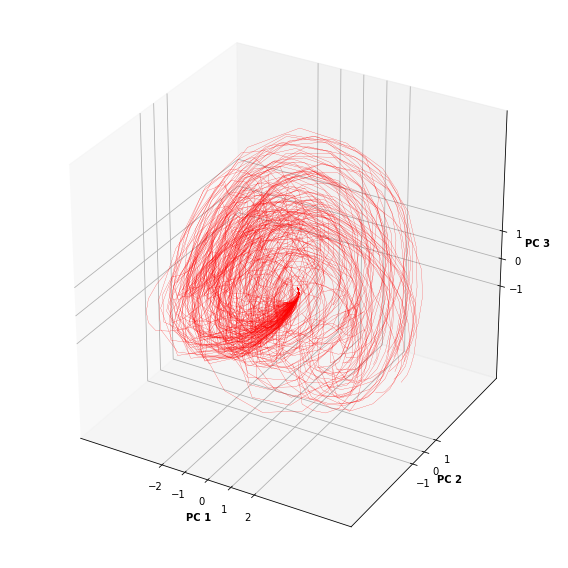

In [ ]:
plot_fps(hiddens,
        plot_batch_idx=range(128),
        plot_start_time=0,
        plot_stop_time = 28,
        is_lif=True)

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import numpy as np
import os 
from tensorflow.contrib import rnn
np.random.seed(400)
#import mnist dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("/content/",one_hot=True)


Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /content/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /content/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /content/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /content/t10k-labels-idx1-ubyte.gz


In [ ]:

#define constants
#unrolled through 28 time steps
time_steps=28*28
#hidden LSTM units
num_units=128
#rows of 28 pixels
n_input=1
#learning rate for adam
learning_rate=0.001
#mnist is meant to be classified in 10 classes(0-9).
n_classes=10
#size of batch
batch_size=128

#weights and biases of appropriate shape to accomplish above task
out_weights=tf.Variable(tf.random_normal([num_units,n_classes]))
out_bias=tf.Variable(tf.random_normal([n_classes]))

#defining placeholders
#input image placeholder
x=tf.placeholder("float",[None,time_steps,n_input])
#input label placeholder
y=tf.placeholder("float",[None,n_classes])

#processing the input tensor from [batch_size,n_steps,n_input] to "time_steps" number of [batch_size,n_input] tensors
input=tf.unstack(x ,time_steps,1)
#defining the network
# lstm_layer=rnn.BasicLSTMCell(num_units,forget_bias=1)#,forget_bias=1)
lstm_layer=tf.contrib.rnn.GRUCell(num_units)#,forget_bias=1)
outputs,_=rnn.static_rnn(lstm_layer,input,dtype="float32")


#converting last output of dimension [batch_size,num_units] to [batch_size,n_classes] by out_weight multiplication
prediction=tf.matmul(outputs[-1],out_weights)+out_bias
#loss_function
saver = tf.train.Saver()
loss=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction,labels=y))
#optimization
opt=tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#model evaluation
correct_prediction=tf.equal(tf.argmax(prediction,1),tf.argmax(y,1))
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

#initialize variables
init=tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    iter=1
    while iter<20000:
        batch_x_,batch_y_=mnist.train.next_batch(batch_size=batch_size)
        batch_x=batch_x_.reshape((batch_size,time_steps,n_input))

        sess.run(opt, feed_dict={x: batch_x, y: batch_y_})
        print(batch_x_.shape)
        if iter %10==0:
            acc,hiddens =sess.run([accuracy, outputs],feed_dict={x:batch_x,y:batch_y_})
            los=sess.run(loss,feed_dict={x:batch_x,y:batch_y_})
            
            print("For iter ",iter)
            print("Accuracy ",acc)
            print("Loss ",los)
            print("__________________")

        if iter%100==0:
          #calculating test accuracy
          test_data = mnist.test.images[:128].reshape((-1, time_steps, n_input))
          test_label = mnist.test.labels[:128]
          val_acc,predict,input = sess.run([accuracy,prediction,y], feed_dict={x: test_data, y: test_label})
          print("Testing Accuracy:", val_acc)
          if val_acc>0.96:
            best_val_acc = val_acc
            save_path = saver.save(sess, os.getcwd())
            print("Model saved in path: %s" % save_path)
            break
        iter=iter+1


TensorFlow 1.x selected.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sequences/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /content/sequences/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /content/sequences/t10k-images-idx3-ubyte.gz
Extracting /content/sequences/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https:/

KeyboardInterrupt: ignored

In [ ]:
batch_x_,batch_y_=mnist.train.next_batch(batch_size=32)

import seaborn as sns 
sns.heatmap(batch_x_[0])

IndexError: ignored

In [ ]:
from FixedPointStore import FixedPointStore
from FixedPointSearch import FixedPointSearch
import pickle
import os
from AdaptiveGradNormClip import AdaptiveGradNormClip
from AdaptiveLearningRate import AdaptiveLearningRate
# %tensorflow_version 1.x
# import tensorflow as tf

chkpt = tf.train.get_checkpoint_state(os.getcwd())
with tf.Session() as sess:
  saver.restore(sess, os.getcwd())
  # test_data = mnist.test.images[:128].reshape((-1, time_steps, n_input))
  # test_label = mnist.test.labels[:128]
  # val_acc,predict,input = sess.run([accuracy,prediction,y], feed_dict={x: test_data, y: test_label})
  # print(val_acc)
  inputs = np.zeros([1,1])
  fps = FixedPointSearch(
              'GRU',
              hiddens,
              '/content', 
              cell= lstm_layer,
              sess = sess
              )
  tol_q = 1e-12
  fps.rerun_q_outliers = False
  fps.compute_jacobians = True 
  fps.decompose_jacobians = True 
  fps.sample_states(600,np.array(hiddens),'GRU', 0.4)
  unique, all_fps = fps.find_fixed_points(inputs, save = True)

In [ ]:
from plot_utils import plot_fps
from sklearn import manifold
import pylab
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA

def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)


fps = FixedPointStore(num_inits = 1,
				num_states= 1,
				num_inputs = 1)
dict_d = fps.restore(os.getcwd()+'/fps_saver/fixedPoint_unique.p')
fps.__dict__ = dict_d

plot_fps(fps,
        hiddens,
        plot_batch_idx= range(64),
        plot_start_time= 10,
        plot_stop_time = 500,)
plt.show()

# This part trains and plot the state trajectories for discrete networks trained on hand written sequnetial MNIST task

It is based on the work by [Jong et.al](https://edwin-de-jong.github.io/blog/isl/incremental-sequence-learning.html). Based on [this](https://arxiv.org/pdf/1611.03068.pdf) paper.

In [ ]:
!wget - https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/raw/master/sequences.tar.gz

--2021-04-15 07:07:52--  http://-/
Resolving - (-)... failed: Name or service not known.
wget: unable to resolve host address ‘-’
--2021-04-15 07:07:52--  https://github.com/edwin-de-jong/mnist-digits-stroke-sequence-data/raw/master/sequences.tar.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/edwin-de-jong/mnist-digits-stroke-sequence-data/master/sequences.tar.gz [following]
--2021-04-15 07:07:52--  https://raw.githubusercontent.com/edwin-de-jong/mnist-digits-stroke-sequence-data/master/sequences.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16564892 (16M) [application/octet-stream]

In [ ]:
!tar -xf sequences.tar.gz

In [ ]:
!mkdir data
!mv sequences/ ./data

In [ ]:
!pip install svgwrite

     |████████████████████████████████| 71kB 8.8MB/s 


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
!mkdir save
!mkdir 1r1 
!mv 1r1 save
!mkdir results
!mkdir 1r1
!mv 1r1 results

In [ ]:
!python train.py --model 'lstm' --explabel "1" --num_mixture 17 --rnn_size 200 --num_layers 2 --nrseq_per_batch 50 --nrinputfiles_train 10000 --nrinputfiles_test 5000 --max_seq_length 100 --num_epochs 100000 --eval_every 1  --report_every 100 --save_every_nrbatches 500 --keep_prob 1 --learning_rate 0.0025 --decay_rate .99995 --train_on_own_output_method 0 --sample_from_output 0 --regularization_factor 0.25 --l2_weight_regularization 0 --max_weight_regularization 1 --nrClassOutputVars 10 --discard_classvar_inputs 1 --randomizeSequenceOrder 1 --classweightfactor 0 --curnrtrainexamples 5000 --correctfrac_threshold_inc_nrtrainex 0.8  --useStrokeOutputVars 1 --useClassInputVars 0 --useStrokeLoss 1 --usernn 1 --incremental_nr_trainexamples 0 --incremental_seq_length 0 --current_seq_length 2 --threshold_rmse_stroke 4 --incremental_nr_digits 0 --curnrdigits 10 --test_every_nrbatches 10 --maxnrpoints 10000000 --stat_windowsize_nrsequences 100

Streaming output truncated to the last 5000 lines.
End of batch: time_train 0.10287022590637207 time ev 0.25806689262390137 tdata 2.0293394724527993e-05 tot 0.36093711853027344 batch time 0.3622291088104248 sequences/sec 138.5282849367189
eval train : epoch 15 totbatches 2891 totnrpoints_trained 5609784.0 nrtrainex 10000 curseqlen 100 curnrdigits 10 rmse_stroke 16.779743091604256 rmse_stroke_alldata 14.539258485229473 rmse_stroke_inc 14.438152435939012 correct 0.1 correct_alldata 0.1001 regularization 0.048625533 loss_total -3.71532 avgbias -0.013589441 maxabsbias 0.3249756 avgstate 0.7275743 maxabsstate 98.7731 learningrate 0.0024982505686362657 maxabscorr 0.9499881 maxabsweight 1.7369987 avgweight 0.045429055 runtime 19.5906684199969
End of batch: time_train 0.11066222190856934 time ev 0.2694575786590576 tdata 2.4120012919108074e-05 tot 0.38011980056762695 batch time 0.3816640377044678 sequences/sec 131.5374782511613
eval test : epoch 15 totbatches 2891 totnrpoints_trained 5609784.0 

In [ ]:
import os 
os.getcwd()

'/content'

In [ ]:
!ls data/sequences/

Streaming output truncated to the last 5000 lines.
trainimg-13173-points.txt      trainimg-44675-inputdata.txt
trainimg-13173-targetdata.txt  trainimg-44675-points.txt
trainimg-13174-inputdata.txt   trainimg-44675-targetdata.txt
trainimg-13174-points.txt      trainimg-44676-inputdata.txt
trainimg-13174-targetdata.txt  trainimg-44676-points.txt
trainimg-13175-inputdata.txt   trainimg-44676-targetdata.txt
trainimg-13175-points.txt      trainimg-44677-inputdata.txt
trainimg-13175-targetdata.txt  trainimg-44677-points.txt
trainimg-13176-inputdata.txt   trainimg-44677-targetdata.txt
trainimg-13176-points.txt      trainimg-44678-inputdata.txt
trainimg-13176-targetdata.txt  trainimg-44678-points.txt
trainimg-13177-inputdata.txt   trainimg-44678-targetdata.txt
trainimg-13177-points.txt      trainimg-44679-inputdata.txt
trainimg-13177-targetdata.txt  trainimg-44679-points.txt
trainimg-13178-inputdata.txt   trainimg-44679-targetdata.txt
trainimg-13178-points.txt      trainimg-4467-inputdata.txt


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pdb

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import tf_utils
def plot_fps(
	state_traj=None,
	plot_batch_idx=None,
	plot_start_time=0,
	plot_stop_time=None,
	mode_scale=0.25,
	fig=None,
	is_lif=False,
	cust_idx = None,
	cust_col = 'g',
	plot_points = True,
	plot_custom = False):

	'''Plots a visualization and analysis of the unique fixed points.

	1) Finds a low-dimensional subspace for visualization via PCA. If
	state_traj is provided, PCA is fit to [all of] those RNN state
	trajectories. Otherwise, PCA is fit to the identified unique fixed
	points. This subspace is 3-dimensional if the RNN state dimensionality
	is >= 3.

	2) Plots the PCA representation of the stable unique fixed points as
	black dots.

	3) Plots the PCA representation of the unstable unique fixed points as
	red dots.

	4) Plots the PCA representation of the modes of the Jacobian at each
	fixed point. By default, only unstable modes are plotted.

	5) (optional) Plots example RNN state trajectories as blue lines.

	Args:
		fps: a FixedPoints object. See FixedPoints.py.

		state_traj (optional): [n_batch x n_time x n_states] numpy
		array or LSTMStateTuple with .c and .h as
		[n_batch x n_time x n_states/2] numpy arrays. Contains example
		trials of RNN state trajectories.

		plot_batch_idx (optional): Indices specifying which trials in
		state_traj to plot on top of the fixed points. Default: plot all
		trials.

		plot_start_time (optional): int specifying the first timestep to
		plot in the example trials of state_traj. Default: 0.

		plot_stop_time (optional): int specifying the last timestep to
		plot in the example trials of stat_traj. Default: n_time.

		stop_time (optional):

		mode_scale (optional): Non-negative float specifying the scaling
		of the plotted eigenmodes. A value of 1.0 results in each mode
		plotted as a set of diametrically opposed line segments
		originating at a fixed point, with each segment's length specified
		by the magnitude of the corresponding eigenvalue.

		fig (optional): Matplotlib figure upon which to plot.

	Returns:
		None.
	'''

	FONT_WEIGHT = 'bold'
	if fig is None:
		FIG_WIDTH = 8 # inches
		FIG_HEIGHT = 8 # inches
		fig = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT),
			tight_layout=True)

	if state_traj is not None:
		if tf_utils.is_lstm(state_traj):
			state_traj_bxtxd = tf_utils.convert_from_LSTMStateTuple(
		state_traj)
		else:
			state_traj_bxtxd = state_traj

		[n_batch, n_time, n_states] = state_traj_bxtxd.shape

		# Ensure plot_start_time >= 0
		plot_start_time = np.max([plot_start_time, 0])

		if plot_stop_time is None:
			plot_stop_time = n_time
		else:
			# Ensure plot_stop_time <= n_time
			plot_stop_time = np.min([plot_stop_time, n_time])

		plot_time_idx = range(plot_start_time, plot_stop_time)

	
	n_states = n_states

	if n_states >= 3:
		pca = PCA(n_components=3)

		if state_traj is not None:
			state_traj_btxd = np.reshape(state_traj_bxtxd,
				(n_batch*n_time, n_states))
			pca.fit(state_traj_btxd)


		ax = fig.add_subplot(111, projection='3d')
		# ax = Axes3D(fig)

		ax.set_xlabel('PC 1', fontweight=FONT_WEIGHT)
		ax.set_zlabel('PC 3', fontweight=FONT_WEIGHT)
		ax.set_ylabel('PC 2', fontweight=FONT_WEIGHT)

		# For generating figure in paper.md
		ax.set_xticks([-2, -1, 0, 1, 2])
		ax.set_yticks([-1, 0, 1])
		ax.set_zticks([-1, 0, 1])
	else:
		# For 1D or 0D networks (i.e., never)
		pca = None
		ax = fig.add_subplot(111)
		ax.xlabel('Hidden 1', fontweight=FONT_WEIGHT)
		if n_states == 2:
			ax.ylabel('Hidden 2', fontweight=FONT_WEIGHT)

	if state_traj is not None:
		if plot_batch_idx is None:
			plot_batch_idx = range(n_batch)

		for batch_idx in plot_batch_idx:
			x_idx = state_traj_bxtxd[batch_idx]

			if n_states >= 3:
				z_idx = pca.transform(x_idx[plot_time_idx, :])
			else:
				z_idx = x_idx[plot_time_idx, :]
			plot_123d(ax, z_idx, color='r', linewidth=0.2)
	


	# for angle in range(0, 360):
	# 	ax.view_init(30, angle)
	# 	plt.draw()
	# 	plt.pause(.001)
	# 	# plt.show()
	plt.ion()
	plt.show()
	plt.pause(1e-10)

def plot_123d(ax, z, **kwargs):
	'''Plots in 1D, 2D, or 3D.

	Args:
		ax: Matplotlib figure axis on which to plot everything.

		z: [n x n_states] numpy array containing data to be plotted,
		where n_states is 1, 2, or 3.

		any keyword arguments that can be passed to ax.plot(...).

	Returns:
		None.
	'''
	n_states = z.shape[1]
	if n_states ==3:
		ax.plot(z[:, 0], z[:, 1], z[:, 2], **kwargs)
	elif n_states == 2:
		ax.plot(z[:, 0], z[:, 1], **kwargs)
	elif n_states == 1:
		ax.plot(z, **kwargs)


In [ ]:
import pickle
def restore(path):
	file = open(path,'rb')
	restore_data = file.read()
	file.close()

	hid= pickle.loads(restore_data,encoding='latin1')
	return(hid)
hid = restore('/content/hiddens/hiddens.p')
hid = np.stack(hid, axis=1)

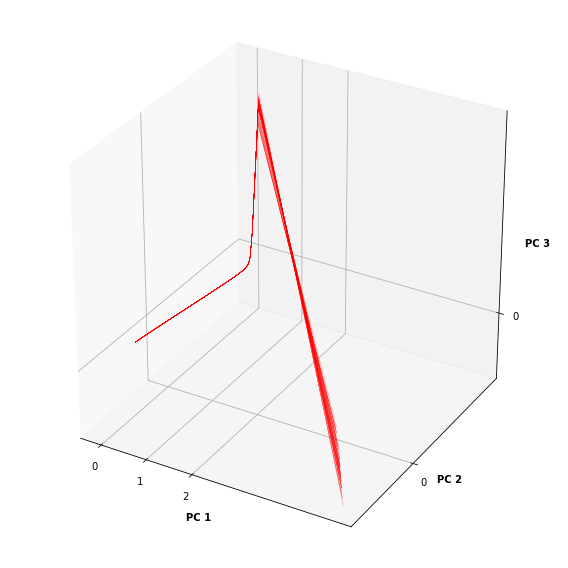

(50, 99, 200)


In [ ]:
import numpy as np
plot_fps(hid,
        plot_batch_idx=range(50),
        plot_start_time=0,
        plot_stop_time = 99,
        is_lif=True)

print(np.array(hid).shape)